In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
# Cell 2: Load AIS data
df = pd.read_csv("../data/ais_cleaned.csv")


In [3]:
# Cell 3: Select and preprocess features
features = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading']
df_clust = df.dropna(subset=features).copy()

X = df_clust[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# Cell 4: DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
df_clust['DBSCAN_Cluster'] = db_labels


In [5]:
# Cell 5: KMeans clustering
k = 4  # adjust k as needed
kmeans = KMeans(n_clusters=k, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)
df_clust['KMeans_Cluster'] = km_labels


In [6]:
# Cell 6: Evaluation metrics
# DBSCAN: exclude outliers (label = -1) for scoring if there are enough core samples
mask_core = db_labels != -1
if mask_core.sum() > 1:
    db_sil_score = silhouette_score(X_scaled[mask_core], db_labels[mask_core])
    db_db_index = davies_bouldin_score(X_scaled[mask_core], db_labels[mask_core])
else:
    db_sil_score = np.nan
    db_db_index = np.nan

km_sil_score = silhouette_score(X_scaled, km_labels)
km_db_index = davies_bouldin_score(X_scaled, km_labels)

metrics = pd.DataFrame({
    'Algorithm': ['DBSCAN', 'KMeans'],
    'Silhouette Score': [db_sil_score, km_sil_score],
    'Davies-Bouldin Index': [db_db_index, km_db_index]
})

print(metrics)


  Algorithm  Silhouette Score  Davies-Bouldin Index
0    DBSCAN          0.453261              0.684200
1    KMeans          0.243852              1.550497


In [18]:
metrics = pd.DataFrame({
    'Algorithm': ['DBSCAN', 'KMeans'],
    'Silhouette Score': [db_sil_score, km_sil_score],
    'Davies-Bouldin Index': [db_db_index, km_db_index]
})
metrics.to_csv("clustering_metrics.csv", index=False)

In [29]:
outlier_count = (df_clust['DBSCAN_Cluster'] == -1).sum()
summary_df = pd.DataFrame({
    'Total Records': [len(df_clust)],
    'Outliers (DBSCAN = -1)': [outlier_count],
    'Outlier Percentage (%)': [round(100 * outlier_count / len(df_clust), 2)]
})


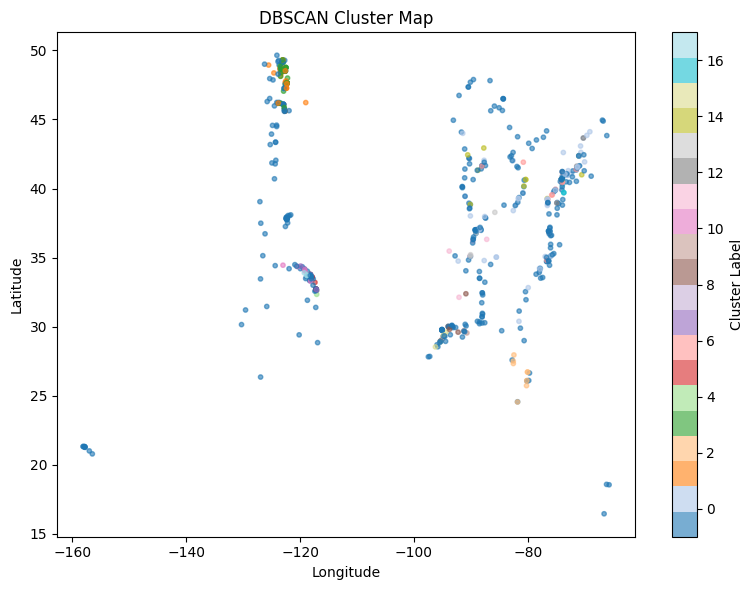

In [26]:
# Cell 7: Visualization - DBSCAN clusters on map
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clust['Longitude'], df_clust['Latitude'],
    c=df_clust['DBSCAN_Cluster'], cmap='tab20', s=10, alpha=0.6
)
plt.title("DBSCAN Cluster Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(scatter, label="Cluster Label")
plt.tight_layout()
plt.savefig("../results/dbscan_cluster_map.png", dpi=300)

plt.show()


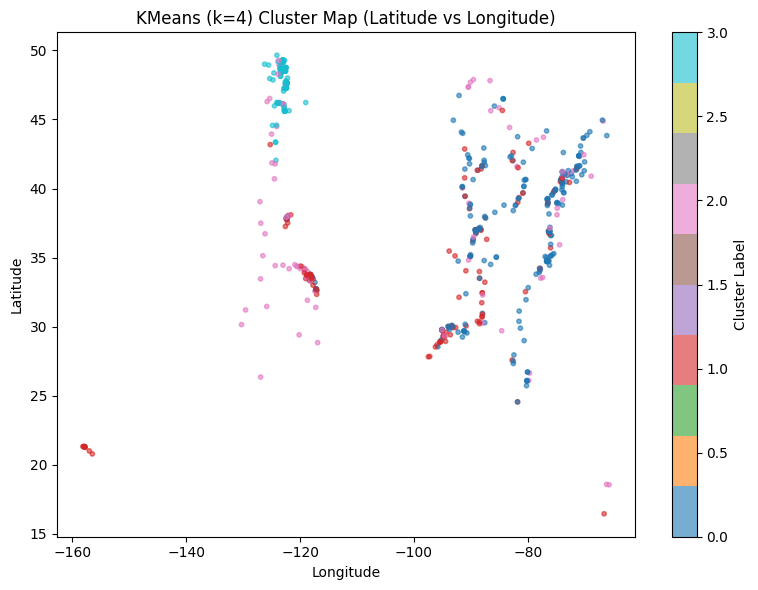

In [25]:
# Cell 8: Visualization - KMeans clusters on map
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clust['Longitude'], df_clust['Latitude'],
    c=df_clust['KMeans_Cluster'], cmap='tab10', s=10, alpha=0.6
)
plt.title(f"KMeans (k={k}) Cluster Map (Latitude vs Longitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(scatter, label="Cluster Label")
plt.tight_layout()
plt.savefig("../results/KMeans_Cluster_map.png", dpi=300)
plt.show()


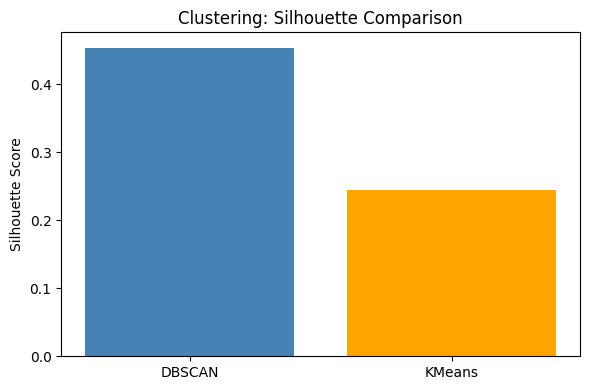

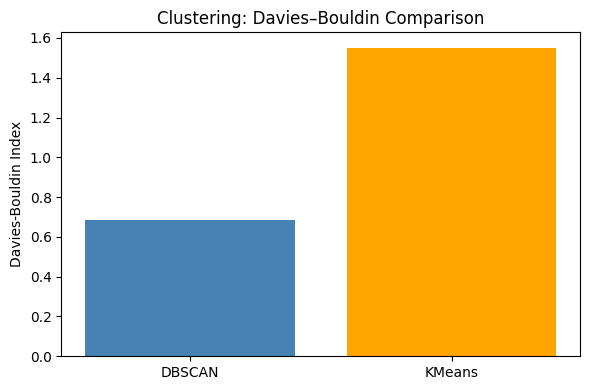

In [24]:
# Cell 9: Performance comparison bar charts
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(metrics['Algorithm'], metrics['Silhouette Score'], color=['steelblue', 'orange'])
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Clustering: Silhouette Comparison")
plt.tight_layout()
plt.savefig("../results/silhouette_score_comparison.png", dpi=300)
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 4))
ax2.bar(metrics['Algorithm'], metrics['Davies-Bouldin Index'], color=['steelblue', 'orange'])
ax2.set_ylabel("Davies-Bouldin Index")
ax2.set_title("Clustering: Davies–Bouldin Comparison")
plt.tight_layout()
plt.savefig("../results/clustering_performance_comparison.png", dpi=300)
plt.show()
